# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os
from torchvision.utils import make_grid

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

real            = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 150
size_minibatch  = 50
dim_latent      = 150
dim_channel     = 1
learning_rate_discriminator = 0.001
learning_rate_generator     = 0.001

In [4]:
import random
def affine(image, shear=0, scale=1, rate=[10, 10]):

    func_plt = transforms.functional.to_pil_image
    func_affine = transforms.functional.affine
    func_tensor = transforms.functional.to_tensor

    for i in range(len(image)):

        # random movement
        if rate[0] != 0:
            rate_1 = np.random.randint(-rate[0], rate[0]+1)
            rate_2 = np.random.randint(-rate[1], rate[1]+1)
            movement = [rate_1, rate_2]
        else:
            movement = rate

        if isinstance(scale, list):
            rescale = np.random.randint(scale[0], scale[1]+1) / 10
        else:
            rescale = scale


        trans_image = func_plt(image[i])
        trans_image = func_affine(trans_image, angle=0, shear=shear, scale=rescale, translate=movement)
        trans_image = func_tensor(trans_image)
        trans_image = trans_image.numpy()

        if i == 0:
            image_list = trans_image
        else:
            image_list = np.concatenate([image_list, trans_image], axis=0)

    return image_list

In [5]:
real_image = real[::2]
affine_12 = affine(real_image, scale=[10, 12], rate=[0, 0])
affine_random = affine(real_image, scale=1, rate=[3, 3])

## custom data loader for the PyTorch framework

In [6]:
class dataset (Dataset):
    def  __init__(self, data):

        self.data = data

    def __getitem__(self, index):

        data = self.data[index]
        data = torch.FloatTensor(data).unsqueeze(dim=0)

        return data
  
    def __len__(self):
        
        return self.data.shape[0]

## construct datasets and dataloaders for training and testing

In [7]:
# image_train = np.concatenate([real[1::2], affine_12, affine_random], axis=0)
dataset_real    = dataset(real)
dataloader_real = DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [8]:
# image_train.shape

## shape of the data when using the data loader

In [9]:
image_real = dataset_real[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_real.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

In [10]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=128):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
			# ================================================================================
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
		)	
		
		self.classifier = nn.Sequential(
			# ================================================================================
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			nn.LeakyReLU(threshold_ReLU, inplace=True),			
			# ================================================================================
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			# ================================================================================
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [11]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			# ================================================================================
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			# ================================================================================
			nn.Sigmoid(),
			# ================================================================================
		) 			

		self.initialize_weight()
		
		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass


## build network

In [12]:
generator       = Generator(dim_latent, 1, 128).to(device)
discriminator   = Discriminator(dim_channel, 1, 128).to(device)

optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate_generator, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_discriminator, betas=(0.5, 0.999))

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform


## compute the prediction

In [13]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [14]:
def compute_loss_discriminator(generator, discriminator, latent, data_real):

    data_fake       = compute_prediction(generator, latent)
    prediction_real = compute_prediction(discriminator, data_real)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion   = nn.BCEWithLogitsLoss()
    
    label_real  = torch.ones_like(prediction_real)
    label_fake  = torch.zeros_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_real = criterion(prediction_real, label_real)
    loss_fake = criterion(prediction_fake, label_fake)
    # 
    # ==================================================

    loss_discriminator = (loss_real + loss_fake) / 2.0

    return loss_discriminator

In [15]:
def compute_loss_generator(generator, discriminator, latent):

    data_fake       = compute_prediction(generator, latent)
    prediction_fake = compute_prediction(discriminator, data_fake)

    criterion       = nn.BCEWithLogitsLoss()

    label_real      = torch.ones_like(prediction_fake)

    # ==================================================
    # fill up the blank
    #    
    loss_generator  = criterion(prediction_fake, label_real)
    # 
    # ==================================================

    return loss_generator

## compute the accuracy

In [16]:
def get_center_index(binary_image):
    
    area_square = np.sum(binary_image)

    height = binary_image.shape[0]
    width = binary_image.shape[1]

    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    indices_X, indices_Y = np.meshgrid(x, y)

    x_mean = np.sum(binary_image * indices_X) / area_square
    y_mean = np.sum(binary_image * indices_Y) / area_square

    return (x_mean, y_mean)

In [17]:
# create ideal square image which has the same area to the input image
def create_label(binary_images):
    
    label = np.zeros_like(binary_images)
    
    for i, binary_image in enumerate(binary_images):
        
        image_height = binary_image.shape[0]
        image_width = binary_image.shape[1]

        square_image = np.zeros((image_height, image_width))
        square_length = np.round(np.sqrt(np.sum(binary_image)))

        if square_length == 0:
            # when there is no square
            return square_image

        (square_center_x, square_center_y) = get_center_index(binary_image)

        if square_center_x < 0 or square_center_x > image_width - 1 or square_center_y < 0 or square_center_y > image_height - 1:
            return square_image

        top = np.ceil(square_center_y - square_length / 2)
        bottom = np.floor(square_center_y + square_length / 2)
        left = np.ceil(square_center_x - square_length / 2)
        right = np.floor(square_center_x + square_length / 2)

        top = int(top) if top >= 0 else 0
        bottom = int(bottom) if bottom <= image_height - 1 else image_height - 1
        left = int(left) if left >= 0 else 0
        right = int(right) if right <= image_width - 1 else image_width - 1

        square_image[top : bottom + 1, left : right + 1] = 1
        
        label[i] = square_image
        
    return label

In [18]:
def compute_accuracy(prediction):

    prediction  = prediction.squeeze(axis=1)
    
    prediction_binary   = (prediction >= 0.5).cpu().numpy().astype(int)
    label               = create_label(prediction_binary).astype(int)
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [19]:
loss_generator_mean     = np.zeros(number_epoch)
loss_generator_std      = np.zeros(number_epoch)
loss_discriminator_mean = np.zeros(number_epoch)
loss_discriminator_std  = np.zeros(number_epoch)

accuracy_mean   = np.zeros(number_epoch)
accuracy_std    = np.zeros(number_epoch)

## train

In [20]:
def train(generator, discriminator, dataloader):

    loss_epoch_generator      = []
    loss_epoch_discriminator  = []
    accuracy_epoch = []
    
    for index_batch, data_real in enumerate(dataloader):

        size_batch  = len(data_real)
        data_real   = data_real.to(device)
        
        latent  = torch.randn(size_batch, dim_latent, device=device)
        latent  = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        optimizer_generator.zero_grad()
        loss_generator = compute_loss_generator(generator, discriminator, latent)
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        optimizer_discriminator.zero_grad()
        loss_discriminator = compute_loss_discriminator(generator, discriminator, latent, data_real)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        data_fake   = compute_prediction(generator, latent)
        accuracy    = compute_accuracy(data_fake)

        loss_epoch_generator.append(loss_generator.item())
        loss_epoch_discriminator.append(loss_discriminator.item())
        accuracy_epoch.append(accuracy)

    loss_generator_mean_epoch       = np.mean(loss_epoch_generator)
    loss_generator_std_epoch        = np.std(loss_epoch_generator)
    
    loss_discriminator_mean_epoch   = np.mean(loss_epoch_discriminator)
    loss_discriminator_std_epoch    = np.std(loss_epoch_discriminator)

    accuracy_mean_epoch             = np.mean(accuracy_epoch)
    accuracy_std_epoch              = np.std(accuracy_epoch)

    loss_value_generator        = {'mean' : loss_generator_mean_epoch, 'std' : loss_generator_std_epoch}
    loss_value_discriminator    = {'mean' : loss_discriminator_mean_epoch, 'std' : loss_discriminator_std_epoch}
    accuracy_value              = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch} 

    return loss_value_generator, loss_value_discriminator, accuracy_value


## training epoch

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_value_generator, loss_value_discriminator, accuracy_value) = train(generator, discriminator, dataloader_real)

    loss_generator_mean[i]      = loss_value_generator['mean']
    loss_generator_std[i]       = loss_value_generator['std']

    loss_discriminator_mean[i]  = loss_value_discriminator['mean']
    loss_discriminator_std[i]   = loss_value_discriminator['std']

    accuracy_mean[i]            = accuracy_value['mean']
    accuracy_std[i]             = accuracy_value['std']

    print(f"epoch : {i}")
    print(f"\tloss_value_discriminator : {loss_value_discriminator['mean']}, acc mean : {accuracy_value['mean']}")

  1%|          | 1/150 [00:17<44:12, 17.80s/it]

epoch : 0
	loss_value_discriminator : 38.52893625650295, acc mean : 84.98511564389372


  1%|▏         | 2/150 [00:35<43:53, 17.79s/it]

epoch : 1
	loss_value_discriminator : 0.7340914724871169, acc mean : 77.83752806497587


  2%|▏         | 3/150 [00:53<43:36, 17.80s/it]

epoch : 2
	loss_value_discriminator : 0.8048134466936422, acc mean : 77.07175976485705


  3%|▎         | 4/150 [01:11<43:19, 17.80s/it]

epoch : 3
	loss_value_discriminator : 1.5537468293725059, acc mean : 69.61989201143834


  3%|▎         | 5/150 [01:28<43:00, 17.80s/it]

epoch : 4
	loss_value_discriminator : 0.5697234503405039, acc mean : 66.79112729554491


  4%|▍         | 6/150 [01:46<42:43, 17.80s/it]

epoch : 5
	loss_value_discriminator : 0.3704193295521099, acc mean : 62.175168257739465


  5%|▍         | 7/150 [02:04<42:25, 17.80s/it]

epoch : 6
	loss_value_discriminator : 0.2940898677983949, acc mean : 55.116618821697315


  5%|▌         | 8/150 [02:22<42:06, 17.80s/it]

epoch : 7
	loss_value_discriminator : 0.5535918626241213, acc mean : 45.06326570614684


  6%|▌         | 9/150 [02:40<41:49, 17.80s/it]

epoch : 8
	loss_value_discriminator : 0.2876463205185394, acc mean : 52.2589655254727


  7%|▋         | 10/150 [02:57<41:31, 17.80s/it]

epoch : 9
	loss_value_discriminator : 0.20375885645490746, acc mean : 67.89406880325849


  7%|▋         | 11/150 [03:15<41:11, 17.78s/it]

epoch : 10
	loss_value_discriminator : 0.19451362358102964, acc mean : 71.56556985529151


  8%|▊         | 12/150 [03:33<40:43, 17.70s/it]

epoch : 11
	loss_value_discriminator : 0.2723637479249128, acc mean : 50.097008485180766


  9%|▊         | 13/150 [03:50<40:18, 17.65s/it]

epoch : 12
	loss_value_discriminator : 0.2700085657063958, acc mean : 51.886875863119045


  9%|▉         | 14/150 [04:08<40:03, 17.67s/it]

epoch : 13
	loss_value_discriminator : 0.2588343544494967, acc mean : 69.94927599044689


 10%|█         | 15/150 [04:26<39:42, 17.65s/it]

epoch : 14
	loss_value_discriminator : 0.32746228354788104, acc mean : 57.21054726192397


 11%|█         | 16/150 [04:43<39:06, 17.51s/it]

epoch : 15
	loss_value_discriminator : 0.31837174781533173, acc mean : 16.38271581688318


 11%|█▏        | 17/150 [05:00<38:50, 17.53s/it]

epoch : 16
	loss_value_discriminator : 0.26084106068971546, acc mean : 54.24866701421019


 12%|█▏        | 18/150 [05:18<38:27, 17.48s/it]

epoch : 17
	loss_value_discriminator : 0.454741392977709, acc mean : 36.46100316519133


 13%|█▎        | 19/150 [05:35<38:02, 17.43s/it]

epoch : 18
	loss_value_discriminator : 0.4055384145399859, acc mean : 26.154648723053803


 13%|█▎        | 20/150 [05:52<37:47, 17.44s/it]

epoch : 19
	loss_value_discriminator : 0.3954028016779312, acc mean : 46.78076291786227


 14%|█▍        | 21/150 [06:10<37:17, 17.34s/it]

epoch : 20
	loss_value_discriminator : 0.4674202167364054, acc mean : 6.809667979205084


 15%|█▍        | 22/150 [06:27<36:56, 17.31s/it]

epoch : 21
	loss_value_discriminator : 0.40815011801761253, acc mean : 19.865961428620192


 15%|█▌        | 23/150 [06:44<36:32, 17.26s/it]

epoch : 22
	loss_value_discriminator : 0.48276952732094497, acc mean : 10.674139837028639


 16%|█▌        | 24/150 [07:01<36:10, 17.23s/it]

epoch : 23
	loss_value_discriminator : 0.442881154286307, acc mean : 5.9421278480893065


 17%|█▋        | 25/150 [07:18<35:52, 17.22s/it]

epoch : 24
	loss_value_discriminator : 0.422186074561851, acc mean : 9.913897169817584


 17%|█▋        | 26/150 [07:36<35:39, 17.25s/it]

epoch : 25
	loss_value_discriminator : 0.41372248097214587, acc mean : 31.927394859417237


 18%|█▊        | 27/150 [07:53<35:20, 17.24s/it]

epoch : 26
	loss_value_discriminator : 0.3803139568934607, acc mean : 9.886805838348216


 19%|█▊        | 28/150 [08:10<34:59, 17.21s/it]

epoch : 27
	loss_value_discriminator : 0.4609127885033918, acc mean : 8.995614538739563


 19%|█▉        | 29/150 [08:27<34:43, 17.22s/it]

epoch : 28
	loss_value_discriminator : 0.4141355550219846, acc mean : 12.038999962245976


 20%|██        | 30/150 [08:45<34:30, 17.25s/it]

epoch : 29
	loss_value_discriminator : 0.40522887072590896, acc mean : 22.04692347032874


 21%|██        | 31/150 [09:02<34:21, 17.32s/it]

epoch : 30
	loss_value_discriminator : 0.4416707437052283, acc mean : 39.710968559024906


 21%|██▏       | 32/150 [09:20<34:08, 17.36s/it]

epoch : 31
	loss_value_discriminator : 0.4394703436382981, acc mean : 36.718181469801955


 22%|██▏       | 33/150 [09:37<34:00, 17.44s/it]

epoch : 32
	loss_value_discriminator : 0.38594263272230017, acc mean : 59.6911567301711


 23%|██▎       | 34/150 [09:55<33:48, 17.48s/it]

epoch : 33
	loss_value_discriminator : 0.42277157012113303, acc mean : 65.84976133479769


 23%|██▎       | 35/150 [10:12<33:31, 17.49s/it]

epoch : 34
	loss_value_discriminator : 0.4551149849281755, acc mean : 43.191624285693536


 24%|██▍       | 36/150 [10:30<33:14, 17.50s/it]

epoch : 35
	loss_value_discriminator : 0.4498825722135777, acc mean : 48.58588917606788


 25%|██▍       | 37/150 [10:47<33:03, 17.56s/it]

epoch : 36
	loss_value_discriminator : 0.4305955343121706, acc mean : 78.44666947454328


 25%|██▌       | 38/150 [11:05<32:48, 17.58s/it]

epoch : 37
	loss_value_discriminator : 0.4627960059185361, acc mean : 61.76822631896976


 26%|██▌       | 39/150 [11:23<32:33, 17.60s/it]

epoch : 38
	loss_value_discriminator : 0.47613164349350817, acc mean : 71.89449475843765


 27%|██▋       | 40/150 [11:40<32:16, 17.61s/it]

epoch : 39
	loss_value_discriminator : 0.5034830119720725, acc mean : 65.1007977634277


 27%|██▋       | 41/150 [11:58<32:02, 17.64s/it]

epoch : 40
	loss_value_discriminator : 0.48331812821155373, acc mean : 77.71403843517875


 28%|██▊       | 42/150 [12:16<31:47, 17.66s/it]

epoch : 41
	loss_value_discriminator : 0.42371622195770575, acc mean : 70.96004343057426


 29%|██▊       | 43/150 [12:33<31:29, 17.66s/it]

epoch : 42
	loss_value_discriminator : 0.5599394662435665, acc mean : 64.52948658923835


 29%|██▉       | 44/150 [12:51<31:10, 17.65s/it]

epoch : 43
	loss_value_discriminator : 0.5076779251874879, acc mean : 58.84729523826033


 30%|███       | 45/150 [13:09<30:55, 17.67s/it]

epoch : 44
	loss_value_discriminator : 0.517694694358249, acc mean : 72.59107695876905


 31%|███       | 46/150 [13:27<30:39, 17.69s/it]

epoch : 45
	loss_value_discriminator : 0.5137284971600355, acc mean : 78.26745998296641


 31%|███▏      | 47/150 [13:44<30:23, 17.70s/it]

epoch : 46
	loss_value_discriminator : 0.48594606026660564, acc mean : 83.1471003798052


 32%|███▏      | 48/150 [14:02<30:07, 17.72s/it]

epoch : 47
	loss_value_discriminator : 0.5301517213499823, acc mean : 78.65767930240338


 33%|███▎      | 49/150 [14:20<29:48, 17.70s/it]

epoch : 48
	loss_value_discriminator : 0.5577222278644872, acc mean : 69.4985808984356


 33%|███▎      | 50/150 [14:37<29:32, 17.73s/it]

epoch : 49
	loss_value_discriminator : 0.53485709740672, acc mean : 84.57423275238445


 34%|███▍      | 51/150 [14:55<29:16, 17.75s/it]

epoch : 50
	loss_value_discriminator : 0.6003564987764802, acc mean : 75.53133739675854


 35%|███▍      | 52/150 [15:13<28:57, 17.73s/it]

epoch : 51
	loss_value_discriminator : 0.5498096530520639, acc mean : 76.40570341400482


 35%|███▌      | 53/150 [15:31<28:40, 17.73s/it]

epoch : 52
	loss_value_discriminator : 0.59773060610128, acc mean : 75.69955526096119


 36%|███▌      | 54/150 [15:48<28:24, 17.75s/it]

epoch : 53
	loss_value_discriminator : 0.5800820128169171, acc mean : 87.2751915057971


 37%|███▋      | 55/150 [16:06<28:07, 17.76s/it]

epoch : 54
	loss_value_discriminator : 0.5289509622163551, acc mean : 84.91567863762312


 37%|███▋      | 56/150 [16:24<27:50, 17.77s/it]

epoch : 55
	loss_value_discriminator : 0.5435541577117388, acc mean : 82.9028841638195


 38%|███▊      | 57/150 [16:42<27:32, 17.77s/it]

epoch : 56
	loss_value_discriminator : 17760458.395856395, acc mean : 67.49620408522571


 39%|███▊      | 58/150 [16:59<26:53, 17.54s/it]

epoch : 57
	loss_value_discriminator : 41650.2756333462, acc mean : 2.022130476276043


 39%|███▉      | 59/150 [17:16<26:17, 17.33s/it]

epoch : 58
	loss_value_discriminator : 8208.219163761583, acc mean : 0.0


 40%|████      | 60/150 [17:33<25:47, 17.19s/it]

epoch : 59
	loss_value_discriminator : 9017.252601091252, acc mean : 0.0


 41%|████      | 61/150 [17:49<25:20, 17.09s/it]

epoch : 60
	loss_value_discriminator : 8444.744147722111, acc mean : 0.0


 41%|████▏     | 62/150 [18:06<24:56, 17.01s/it]

epoch : 61
	loss_value_discriminator : 6848.488424611646, acc mean : 0.0


 42%|████▏     | 63/150 [18:23<24:36, 16.97s/it]

epoch : 62
	loss_value_discriminator : 6067.532703488372, acc mean : 0.0


 43%|████▎     | 64/150 [18:40<24:21, 17.00s/it]

epoch : 63
	loss_value_discriminator : 4175.48517413472, acc mean : 3.2220206697484386


 43%|████▎     | 65/150 [18:57<24:04, 16.99s/it]

epoch : 64
	loss_value_discriminator : 2462.5018784279046, acc mean : 0.0


 44%|████▍     | 66/150 [19:14<23:47, 16.99s/it]

epoch : 65
	loss_value_discriminator : 1876.7466986013014, acc mean : 0.0


 45%|████▍     | 67/150 [19:31<23:29, 16.98s/it]

epoch : 66
	loss_value_discriminator : 1489.9275340590366, acc mean : 0.0


 45%|████▌     | 68/150 [19:48<23:16, 17.03s/it]

epoch : 67
	loss_value_discriminator : 1088.4493556355321, acc mean : 3.273304655739028


 46%|████▌     | 69/150 [20:06<23:06, 17.11s/it]

epoch : 68
	loss_value_discriminator : 789.2879105501397, acc mean : 10.971433471513404


 47%|████▋     | 70/150 [20:23<23:00, 17.25s/it]

epoch : 69
	loss_value_discriminator : 568.1952600479126, acc mean : 42.10944737015685


 47%|████▋     | 71/150 [20:41<22:49, 17.33s/it]

epoch : 70
	loss_value_discriminator : 942.5372766006825, acc mean : 34.26703430118939


 48%|████▊     | 72/150 [20:58<22:33, 17.35s/it]

epoch : 71
	loss_value_discriminator : 566.0256708499998, acc mean : 22.497248137412676


 49%|████▊     | 73/150 [21:15<22:17, 17.37s/it]

epoch : 72
	loss_value_discriminator : 535.6642354699069, acc mean : 27.3430390526177


 49%|████▉     | 74/150 [21:33<21:56, 17.33s/it]

epoch : 73
	loss_value_discriminator : 1247.0600653360057, acc mean : 11.264978209733158


 50%|█████     | 75/150 [21:50<21:36, 17.29s/it]

epoch : 74
	loss_value_discriminator : 810.720755699069, acc mean : 12.417494680691735


 51%|█████     | 76/150 [22:07<21:20, 17.30s/it]

epoch : 75
	loss_value_discriminator : 357.821535239386, acc mean : 13.313157586878448


 51%|█████▏    | 77/150 [22:25<21:03, 17.31s/it]

epoch : 76
	loss_value_discriminator : 369.93313791585524, acc mean : 22.485847738583587


 52%|█████▏    | 78/150 [22:42<20:46, 17.31s/it]

epoch : 77
	loss_value_discriminator : 447.9989472655363, acc mean : 12.709874005993335


 53%|█████▎    | 79/150 [22:59<20:28, 17.30s/it]

epoch : 78
	loss_value_discriminator : 216.73542321837226, acc mean : 16.273500887353865


 53%|█████▎    | 80/150 [23:16<20:09, 17.28s/it]

epoch : 79
	loss_value_discriminator : 261.45820513922115, acc mean : 8.135451513787658


 54%|█████▍    | 81/150 [23:33<19:49, 17.23s/it]

epoch : 80
	loss_value_discriminator : 796.5788655613744, acc mean : 5.237894168376381


 55%|█████▍    | 82/150 [23:51<19:29, 17.20s/it]

epoch : 81
	loss_value_discriminator : 1188.8074034535607, acc mean : 4.39456100085289


 55%|█████▌    | 83/150 [24:08<19:08, 17.14s/it]

epoch : 82
	loss_value_discriminator : 1561.0458157561545, acc mean : 0.0


 56%|█████▌    | 84/150 [24:25<18:50, 17.13s/it]

epoch : 83
	loss_value_discriminator : 681.6581223551617, acc mean : 4.507249408245736


 57%|█████▋    | 85/150 [24:42<18:35, 17.16s/it]

epoch : 84
	loss_value_discriminator : 232.70153576551482, acc mean : 9.293244253313176


 57%|█████▋    | 86/150 [24:59<18:16, 17.14s/it]

epoch : 85
	loss_value_discriminator : 222.53736577477565, acc mean : 4.723239804123509


 58%|█████▊    | 87/150 [25:16<17:56, 17.10s/it]

epoch : 86
	loss_value_discriminator : 265.31423225686996, acc mean : 0.0


 59%|█████▊    | 88/150 [25:33<17:36, 17.05s/it]

epoch : 87
	loss_value_discriminator : 3011.010321983071, acc mean : 0.0


 59%|█████▉    | 89/150 [25:50<17:15, 16.98s/it]

epoch : 88
	loss_value_discriminator : 1019.1919607339903, acc mean : 0.0


 60%|██████    | 90/150 [26:07<16:56, 16.94s/it]

epoch : 89
	loss_value_discriminator : 4562.80878787817, acc mean : 0.0


 61%|██████    | 91/150 [26:23<16:37, 16.91s/it]

epoch : 90
	loss_value_discriminator : 990.4322858632997, acc mean : 0.0


 61%|██████▏   | 92/150 [26:40<16:19, 16.89s/it]

epoch : 91
	loss_value_discriminator : 616.4804131520349, acc mean : 0.0


 62%|██████▏   | 93/150 [26:57<16:01, 16.87s/it]

epoch : 92
	loss_value_discriminator : 328.90660854827524, acc mean : 0.0


 63%|██████▎   | 94/150 [27:14<15:43, 16.86s/it]

epoch : 93
	loss_value_discriminator : 566.0324213615684, acc mean : 0.0


 63%|██████▎   | 95/150 [27:31<15:26, 16.85s/it]

epoch : 94
	loss_value_discriminator : 409.6472577050675, acc mean : 0.0


 64%|██████▍   | 96/150 [27:48<15:09, 16.85s/it]

epoch : 95
	loss_value_discriminator : 765.4865125999894, acc mean : 0.0


 65%|██████▍   | 97/150 [28:04<14:52, 16.85s/it]

epoch : 96
	loss_value_discriminator : 632.192338939323, acc mean : 0.0


 65%|██████▌   | 98/150 [28:21<14:35, 16.85s/it]

epoch : 97
	loss_value_discriminator : 373.52792584757475, acc mean : 0.0


 66%|██████▌   | 99/150 [28:38<14:19, 16.85s/it]

epoch : 98
	loss_value_discriminator : 372.81283459344576, acc mean : 0.0


 67%|██████▋   | 100/150 [28:55<14:02, 16.85s/it]

epoch : 99
	loss_value_discriminator : 678.8373325702756, acc mean : 0.0


 67%|██████▋   | 101/150 [29:12<13:45, 16.85s/it]

epoch : 100
	loss_value_discriminator : 775.8329238170801, acc mean : 0.0


 68%|██████▊   | 102/150 [29:29<13:28, 16.84s/it]

epoch : 101
	loss_value_discriminator : 261.5426883409605, acc mean : 0.0


 69%|██████▊   | 103/150 [29:46<13:11, 16.84s/it]

epoch : 102
	loss_value_discriminator : 1205.0921772818926, acc mean : 0.0


 69%|██████▉   | 104/150 [30:02<12:54, 16.83s/it]

epoch : 103
	loss_value_discriminator : 184.8346830925276, acc mean : 0.0


 70%|███████   | 105/150 [30:19<12:37, 16.83s/it]

epoch : 104
	loss_value_discriminator : 131.9536239754322, acc mean : 0.0


 71%|███████   | 106/150 [30:36<12:20, 16.83s/it]

epoch : 105
	loss_value_discriminator : 1372.5369160447356, acc mean : 0.0


 71%|███████▏  | 107/150 [30:53<12:03, 16.83s/it]

epoch : 106
	loss_value_discriminator : 156.86049337026685, acc mean : 0.0


 72%|███████▏  | 108/150 [31:10<11:46, 16.83s/it]

epoch : 107
	loss_value_discriminator : 127.25182690400024, acc mean : 0.0


 73%|███████▎  | 109/150 [31:26<11:29, 16.83s/it]

epoch : 108
	loss_value_discriminator : 198.93311214724253, acc mean : 0.0


 73%|███████▎  | 110/150 [31:43<11:12, 16.82s/it]

epoch : 109
	loss_value_discriminator : 228.78657111040383, acc mean : 0.0


 74%|███████▍  | 111/150 [32:00<10:56, 16.83s/it]

epoch : 110
	loss_value_discriminator : 47.63798976602943, acc mean : 0.0


 75%|███████▍  | 112/150 [32:17<10:39, 16.83s/it]

epoch : 111
	loss_value_discriminator : 35.967675267978635, acc mean : 0.0


 75%|███████▌  | 113/150 [32:34<10:22, 16.83s/it]

epoch : 112
	loss_value_discriminator : 522.5958657126095, acc mean : 0.0


 76%|███████▌  | 114/150 [32:51<10:05, 16.82s/it]

epoch : 113
	loss_value_discriminator : 108.6779649160629, acc mean : 0.0


 77%|███████▋  | 115/150 [33:07<09:49, 16.83s/it]

epoch : 114
	loss_value_discriminator : 52.61816970137663, acc mean : 0.0


 77%|███████▋  | 116/150 [33:24<09:32, 16.84s/it]

epoch : 115
	loss_value_discriminator : 103.8048933430813, acc mean : 0.0


 78%|███████▊  | 117/150 [33:41<09:15, 16.84s/it]

epoch : 116
	loss_value_discriminator : 255.990268892327, acc mean : 0.0


 79%|███████▊  | 118/150 [33:58<08:58, 16.84s/it]

epoch : 117
	loss_value_discriminator : 35.46332444425239, acc mean : 0.0


 79%|███████▉  | 119/150 [34:15<08:46, 16.98s/it]

epoch : 118
	loss_value_discriminator : 97278.41078434433, acc mean : 25.765734486495464


 80%|████████  | 120/150 [34:33<08:34, 17.15s/it]

epoch : 119
	loss_value_discriminator : 768.3692031682924, acc mean : 43.46897293756648


 81%|████████  | 121/150 [34:50<08:17, 17.15s/it]

epoch : 120
	loss_value_discriminator : 377.4131488356479, acc mean : 5.707185964136197


 81%|████████▏ | 122/150 [35:07<07:59, 17.13s/it]

epoch : 121
	loss_value_discriminator : 313.2729298347651, acc mean : 1.9250764916669796


 82%|████████▏ | 123/150 [35:24<07:41, 17.10s/it]

epoch : 122
	loss_value_discriminator : 310.74098329765854, acc mean : 0.9582261823808172


 83%|████████▎ | 124/150 [35:41<07:23, 17.06s/it]

epoch : 123
	loss_value_discriminator : 255.36921563259392, acc mean : 0.0


 83%|████████▎ | 125/150 [35:58<07:06, 17.05s/it]

epoch : 124
	loss_value_discriminator : 218.4420415745225, acc mean : 0.0


 84%|████████▍ | 126/150 [36:15<06:49, 17.04s/it]

epoch : 125
	loss_value_discriminator : 204.5102827382642, acc mean : 1.9306704579727096


 85%|████████▍ | 127/150 [36:32<06:31, 17.02s/it]

epoch : 126
	loss_value_discriminator : 165.92682665447856, acc mean : 0.0


 85%|████████▌ | 128/150 [36:49<06:14, 17.01s/it]

epoch : 127
	loss_value_discriminator : 168.30475241638894, acc mean : 0.9684662205355655


 86%|████████▌ | 129/150 [37:06<05:57, 17.00s/it]

epoch : 128
	loss_value_discriminator : 153.86388510327006, acc mean : 0.0


 87%|████████▋ | 130/150 [37:23<05:40, 17.00s/it]

epoch : 129
	loss_value_discriminator : 134.36959621518156, acc mean : 0.9704728786061647


 87%|████████▋ | 131/150 [37:40<05:22, 16.99s/it]

epoch : 130
	loss_value_discriminator : 149.0410845113355, acc mean : 0.0


 88%|████████▊ | 132/150 [37:57<05:06, 17.02s/it]

epoch : 131
	loss_value_discriminator : 127.01242056558299, acc mean : 1.9548719664803036


 89%|████████▊ | 133/150 [38:14<04:49, 17.02s/it]

epoch : 132
	loss_value_discriminator : 111.83512705425883, acc mean : 0.9780985970798198


 89%|████████▉ | 134/150 [38:31<04:32, 17.03s/it]

epoch : 133
	loss_value_discriminator : 105.99602666012076, acc mean : 0.9681627540092527


 90%|█████████ | 135/150 [38:48<04:15, 17.03s/it]

epoch : 134
	loss_value_discriminator : 117.15154920622359, acc mean : 1.9353214538151482


 91%|█████████ | 136/150 [39:05<03:58, 17.03s/it]

epoch : 135
	loss_value_discriminator : 118.54128365183986, acc mean : 0.9700536930356023


 91%|█████████▏| 137/150 [39:22<03:41, 17.04s/it]

epoch : 136
	loss_value_discriminator : 118.42107910333678, acc mean : 0.966852136364475


 92%|█████████▏| 138/150 [39:39<03:24, 17.02s/it]

epoch : 137
	loss_value_discriminator : 83.36181687199792, acc mean : 2.9029419572105444


 93%|█████████▎| 139/150 [39:56<03:07, 17.02s/it]

epoch : 138
	loss_value_discriminator : 70.33537135013314, acc mean : 0.9731486136473563


 93%|█████████▎| 140/150 [40:13<02:50, 17.02s/it]

epoch : 139
	loss_value_discriminator : 60.290603948193926, acc mean : 1.9288075382172898


 94%|█████████▍| 141/150 [40:30<02:33, 17.01s/it]

epoch : 140
	loss_value_discriminator : 52.790510122166125, acc mean : 0.0


 95%|█████████▍| 142/150 [40:47<02:16, 17.00s/it]

epoch : 141
	loss_value_discriminator : 58.0107644047848, acc mean : 0.0


 95%|█████████▌| 143/150 [41:04<01:59, 17.01s/it]

epoch : 142
	loss_value_discriminator : 46.32670843323996, acc mean : 0.9643987701041579


 96%|█████████▌| 144/150 [41:21<01:42, 17.01s/it]

epoch : 143
	loss_value_discriminator : 46.34647419286329, acc mean : 0.9634963066520584


 97%|█████████▋| 145/150 [41:38<01:25, 17.01s/it]

epoch : 144
	loss_value_discriminator : 33.302879882413286, acc mean : 0.9733572821735951


 97%|█████████▋| 146/150 [41:55<01:08, 17.01s/it]

epoch : 145
	loss_value_discriminator : 34.60357183079387, acc mean : 0.9737722885383704


 98%|█████████▊| 147/150 [42:12<00:51, 17.00s/it]

epoch : 146
	loss_value_discriminator : 20.806460447089616, acc mean : 0.0


 99%|█████████▊| 148/150 [42:29<00:34, 17.00s/it]

epoch : 147
	loss_value_discriminator : 42.987779536912605, acc mean : 0.9682693026077688


 99%|█████████▉| 149/150 [42:46<00:17, 17.00s/it]

epoch : 148
	loss_value_discriminator : 21.160645576410516, acc mean : 0.9755970985801519


100%|██████████| 150/150 [43:03<00:00, 17.23s/it]

epoch : 149
	loss_value_discriminator : 18.800819225089494, acc mean : 0.0


---

# functions for visualizing the results 

---

## plot curve

In [22]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [23]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [24]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [25]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [26]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [27]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [28]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [29]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [30]:
def function_result_01():

    print('[plot examples of the real images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_real)
    step        = int(np.floor(number_data / (nRow * nCol)))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data = dataset_real[index_data]
    data = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [31]:
def function_result_02():

    print('[plot examples of the fake images]')
    print('') 

    nRow = 8
    nCol = 6
    number_latent = nRow * nCol

    latent  = torch.randn(number_latent, dim_latent, device=device)
    latent  = torch.reshape(latent, [number_latent, dim_latent, 1, 1])

    generator.eval()

    data_fake   = generator(latent)
    filename    = 'fake_image.png'

    plot_image_grid(data_fake, nRow, nCol, filename)

In [32]:
def function_result_03():

    print('[plot the generator loss]')
    print('') 

    plot_curve_error(loss_generator_mean, loss_generator_std, 'epoch', 'loss', 'generator loss', 'loss_generator.png')

In [33]:
def function_result_04():
    
    print('[plot the discriminator loss]')
    print('') 
    
    plot_curve_error(loss_discriminator_mean, loss_discriminator_std, 'epoch', 'loss', 'discriminator loss', 'loss_discriminator.png')

In [34]:
def function_result_05():
    
    print('[plot the accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean, accuracy_std, 'epoch', 'accuracy', 'training accuracy', 'training_accuracy.png')

In [35]:
def function_result_06():
    
    print('[print the generator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_generator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [36]:
def function_result_07():
    
    print('[print the discriminator loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_discriminator_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_08():
    
    print('[print the accuracy at the last 10 epochs]')
    print('') 

    data_last = get_data_last(accuracy_mean, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_09():
    
    print('[print the best accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean, -10)
    print('best accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the real images]



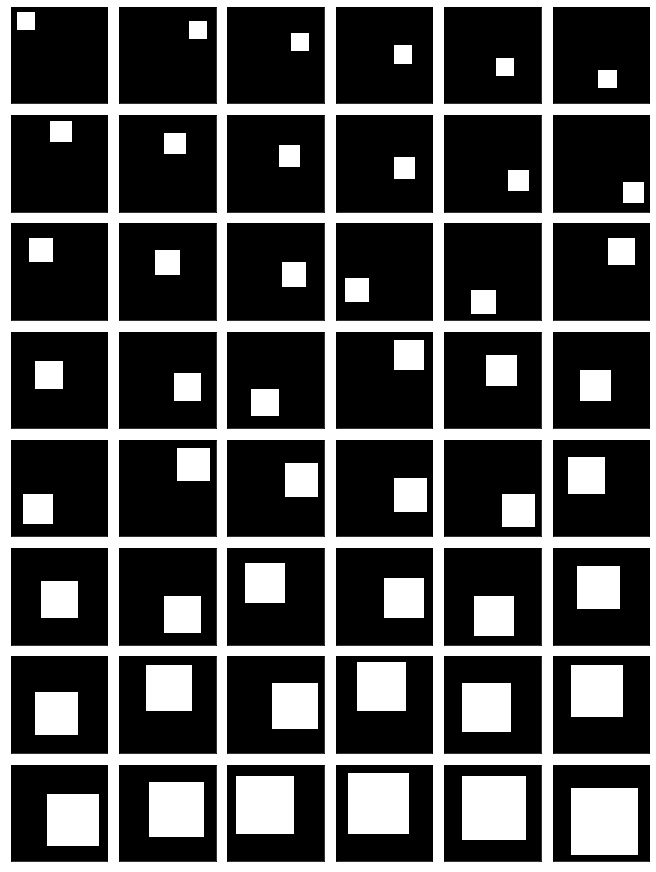


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the fake images]



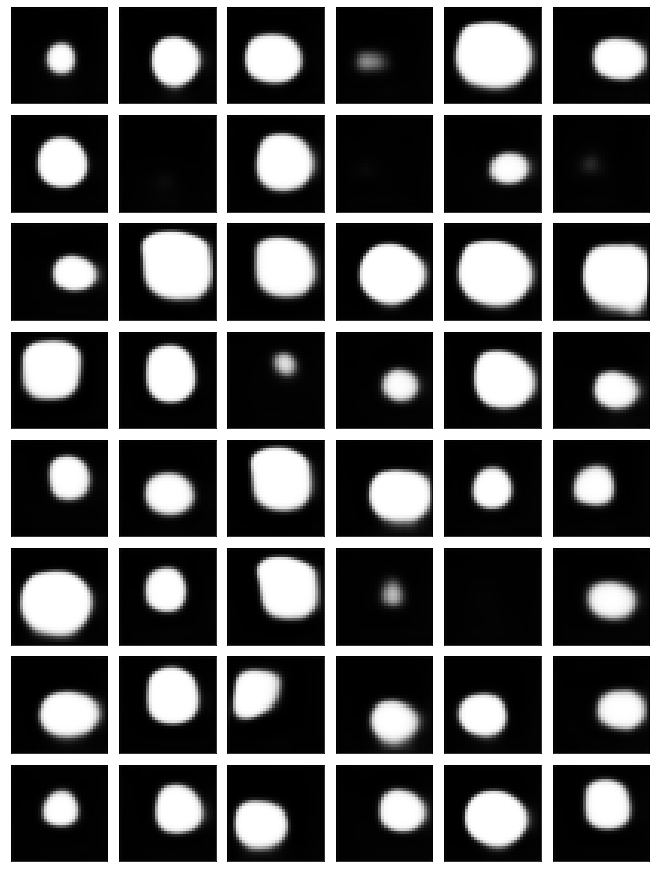


################################################################################
#
# RESULT # 03
#
################################################################################

[plot the generator loss]



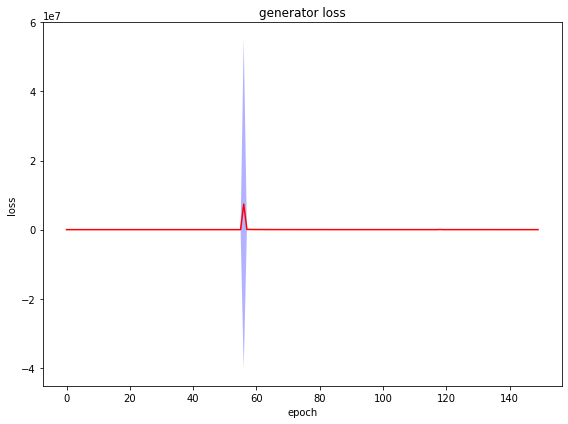


################################################################################
#
# RESULT # 04
#
################################################################################

[plot the discriminator loss]



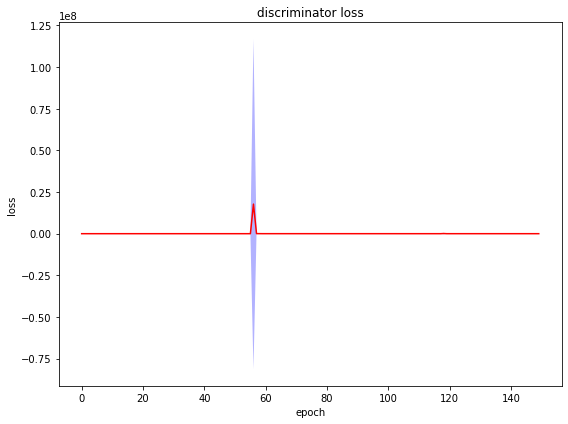


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the accuracy]



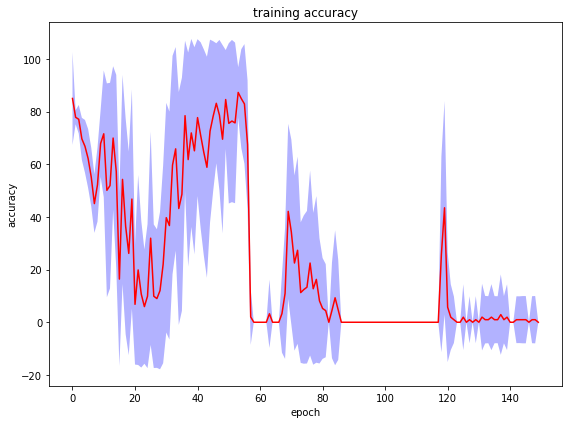


################################################################################
#
# RESULT # 06
#
################################################################################

[print the generator loss at the last 10 epochs]

index =  0, value = 286.3411747688
index =  1, value = 304.1234286081
index =  2, value = 274.4928523108
index =  3, value = 279.2191500553
index =  4, value = 248.7759763030
index =  5, value = 259.7540513416
index =  6, value = 224.4936373955
index =  7, value = 239.3540333094
index =  8, value = 214.6576774176
index =  9, value = 203.8252941952

################################################################################
#
# RESULT # 07
#
################################################################################

[print the discriminator loss at the last 10 epochs]

index =  0, value = 52.7905101222
index =  1, value = 58.0107644048
index =  2, value = 46.3267084332
index =  3, value = 46.3464741929
index =  4, value = 33.3028798824
index =  5, 

In [39]:
number_result = 9

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)